In [ ]:
import jax.numpy as jnp
from jax import vmap
import numpy.random as npr
from jax import jit, grad
import matplotlib.pyplot as plt
from jax.experimental.ode import odeint

In [ ]:
def mlp(params, inputs):
  for w, b in params:
    outputs = jnp.dot(inputs, w) + b
    inputs = jnp.tanh(outputs)
  return outputs

In [ ]:
def resnet(params, inputs, depth):
  for i in range(depth):
    outputs = mlp(params, inputs) + inputs
  return outputs

In [ ]:
resnet_depth = 3
def resnet_squared_loss(params, inputs, targets):
  preds = resnet(params, inputs, resnet_depth)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

@jit
def resnet_update(params, inputs, targets):
  grads = grad(resnet_squared_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

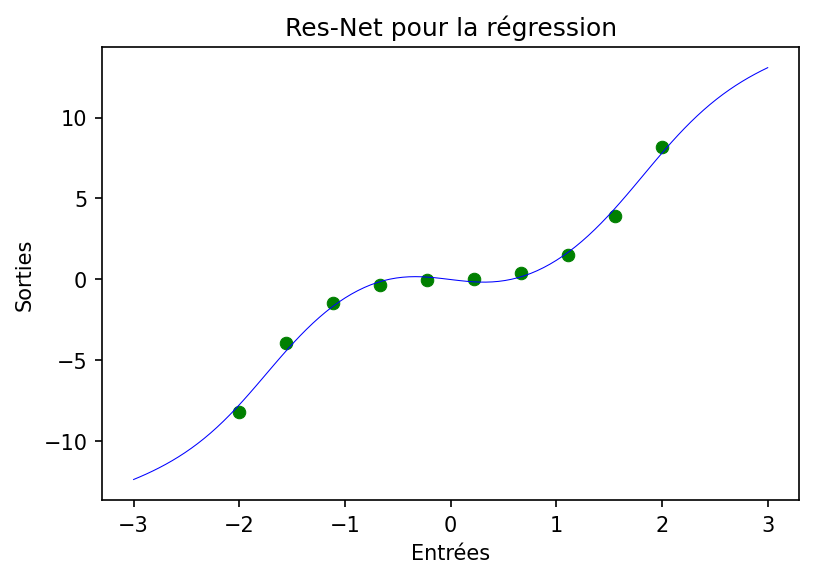

In [ ]:
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, inputs, targets)

fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_title("Res-Net pour la régression")
ax.set_xlabel('Entrées')
ax.set_ylabel('Sorties');

In [ ]:
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state

In [ ]:
batched_odenet = vmap(odenet, in_axes=(None, 0))

In [ ]:
sizes = [
    [2, 2, 1],
    [2, 4, 1],
    [2, 7, 1],
]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

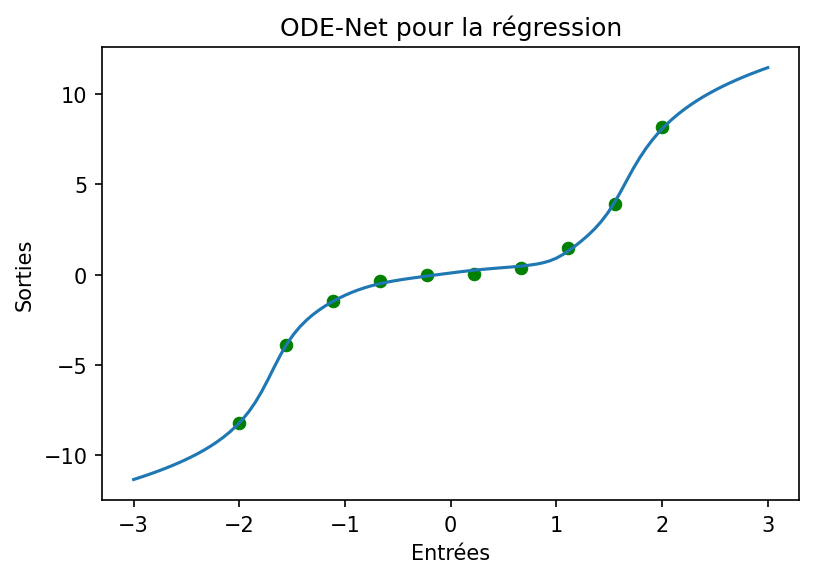

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
odenet_params = init_random_params(param_scale, [2, 15, 1])
for i in range(1000):
    odenet_params = odenet_update(odenet_params, inputs, targets)
preds = batched_odenet(odenet_params, fine_inputs)
ax.plot(fine_inputs, preds)
ax.set_title("ODE-Net pour la régression")
ax.set_xlabel("Entrées")
ax.set_ylabel("Sorties");

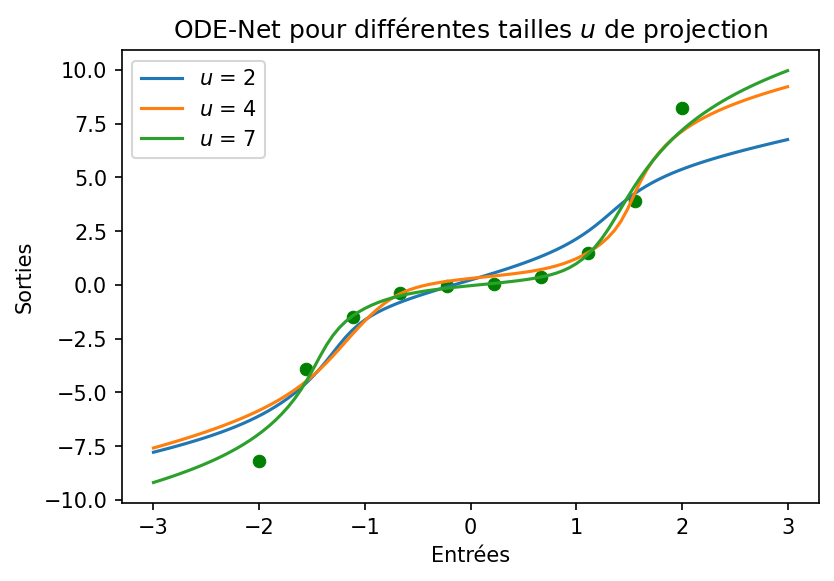

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
for size in sizes:
    odenet_params = init_random_params(param_scale, size)
    for i in range(200):
        odenet_params = odenet_update(odenet_params, inputs, targets)
    preds = batched_odenet(odenet_params, fine_inputs)
    ax.plot(fine_inputs, preds, label=f"$u$ = {size[1]}")
plt.legend()
ax.set_title("ODE-Net pour différentes tailles $u$ de projection")
ax.set_xlabel("Entrées")
ax.set_ylabel("Sorties");

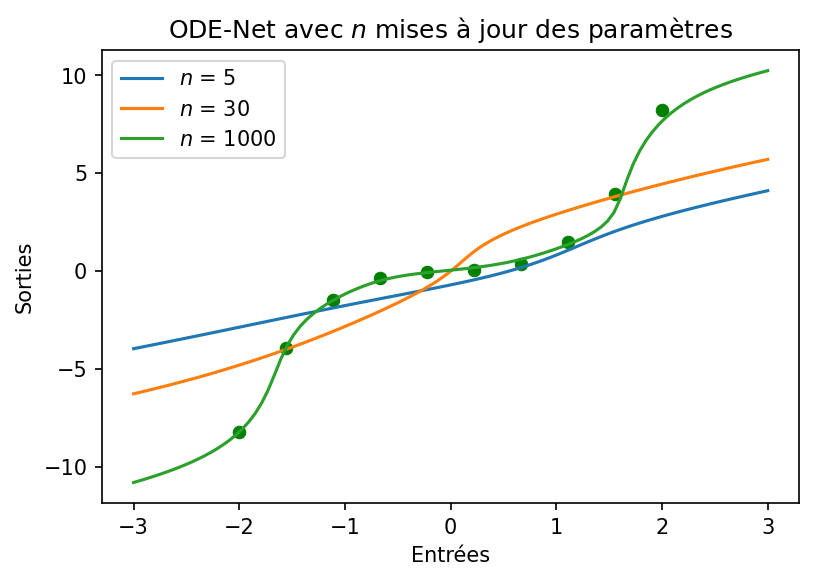

In [ ]:
iters = [
    5,
    30,
    1000
]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
for iter in iters:
    odenet_params = init_random_params(param_scale, [2, 5, 1])
    for i in range(iter):
        odenet_params = odenet_update(odenet_params, inputs, targets)
    preds = batched_odenet(odenet_params, fine_inputs)
    ax.plot(fine_inputs, preds, label=f"$n$ = {iter}")
plt.legend()
ax.set_title("ODE-Net avec $n$ mises à jour des paramètres")
ax.set_xlabel("Entrées")
ax.set_ylabel("Sorties");